#### After preprocessing the data we used support vector machine (SVM) and long-short term memory (LSTM) neural network to classify the non-seizure and seizure EEG signals. 
#### For feature extraction in case of SVM model, we used discrete wavelet transform and statistical features are extracted from the wavelet coefficients in each sub-band.
#### Since the dataset is highly imbalanced in which majority of the samples are from non-seizure, we used SMOTE technique to balanced the dataset.


In [1]:
# we imported all the modules and pacakages
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.optimizers import SGD
from keras_tuner import RandomSearch

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

import keras_tuner as kt
import warnings; warnings.simplefilter('ignore')
import warnings
warnings.filterwarnings('ignore')

#### Dataset A, B, C and D contain the datapoints of non-seizure and dataset E contains the datapoints of seizure We labeled the non-seizure data as class '0' and seizure data as class'1'


In [2]:
# Data loading 
# we used the path of final preprocessed dataset.Each dataset contains 100 files 
# read all the files from sets and concates the files

# DataA
pathA = r'D:/Final_project/Data/merged/A' 
all_filesA = glob.glob(pathA + "/*.csv")

tempA = []

for filename in all_filesA:
    df1 = pd.read_csv(filename, index_col=None, header=0)
    tempA.append(df1)

dfA = pd.concat(tempA, axis=0, ignore_index=True)
dfA.insert(loc=len(dfA.columns), column='Y', value='0', allow_duplicates=True)


# DataB
pathB = r'D:/Final_project/Data/merged/B' 
all_filesB = glob.glob(pathB + "/*.csv")

tempB = []

for filename in all_filesB:
    df2 = pd.read_csv(filename, index_col=None, header=0)
    tempB.append(df2)

dfB = pd.concat(tempB, axis=0, ignore_index=True)
dfB.insert(loc=len(dfB.columns), column='Y', value='0', allow_duplicates=True)

# DataC
pathC = r'D:/Final_project/Data/merged/C' 
all_filesC = glob.glob(pathC + "/*.csv")

tempC = []

for filename in all_filesC:
    df3 = pd.read_csv(filename, index_col=None, header=0)
    tempC.append(df3)

dfC = pd.concat(tempC, axis=0, ignore_index=True)
dfC.insert(loc=len(dfC.columns), column='Y', value='0', allow_duplicates=True)


## Data D
pathD = r'D:/Final_project/Data/merged/D' 
all_filesD = glob.glob(pathD + "/*.csv")

tempD = []

for filename in all_filesD:
    df4 = pd.read_csv(filename, index_col=None, header=0)
    tempD.append(df4)

dfD = pd.concat(tempD, axis=0, ignore_index=True)
dfD.insert(loc=len(dfD.columns), column='Y', value='0', allow_duplicates=True)


## Data E
pathE = r'D:/Final_project/Data/merged/E'
all_filesE = glob.glob(pathE + "/*.csv")

tempE = []

for filename in all_filesE:
    df5 = pd.read_csv(filename, index_col=None, header=0)
    tempE.append(df5)

dfE = pd.concat(tempE, axis=0, ignore_index=True)
dfE.insert(loc=len(dfE.columns), column='Y', value='1', allow_duplicates=True)

In [3]:
df = pd.concat([dfA, dfB,dfC,dfD,dfE], ignore_index=True)

In [4]:
# shape of the dataset
df.shape

(11500, 179)

In [5]:
# size of the dataset
df.size

2058500

In [6]:
# The dataset consists of 11,500 samples with 178 features

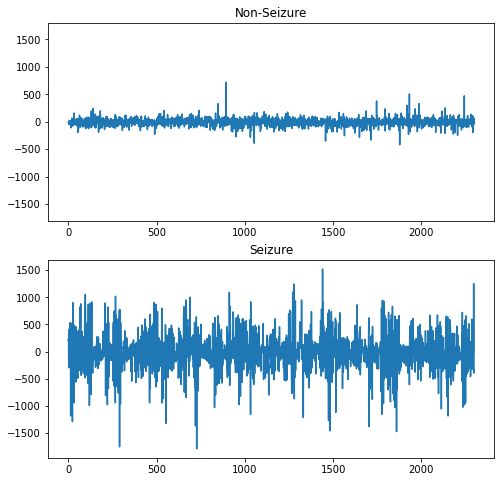

In [9]:
# Visualizing the data points

df_nseiz=pd.concat([dfA, dfB,dfC,dfD], ignore_index=True) # non-seizure dataset (files A, B, C,D)

df_nseiz = shuffle(df_nseiz) # seizure dataset (file E)
df_seiz=dfE

X_ns = df_nseiz.iloc[:,1:177].values
X_s =  df_seiz.iloc[:,1:177].values
samples = np.arange(0,2300,1)

#let us plot the siezure and non-seizure data
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title('Non-Seizure')
plt.plot(samples,X_ns[:2300,0], label = 'Non-Seizure')
plt.ylim(-1800,1800)
plt.subplot(2,1,2)
plt.title('Seizure')
plt.plot(samples,X_s[:,0],label= 'Seizure')
plt.savefig('ns.png')
plt.show()

## feature extraction

In [10]:
# feature extraction using wavelet transform 
# The EEG signal is decomposed using Daubechies wavelet of order 4 (db4)
# and statistical features are extracted from the wavelet coefficients in each sub-band
import pywt

target=df["Y"]
target = target.astype('int')
df2=df.drop(["Y"],axis=1)



# let us define function to calcualte the statiscal features 
def statisticsForWavelet(coefs):
    median = np.nanpercentile(coefs, 50)
    mean = np.nanmean(coefs)
    std = np.nanstd(coefs)
    var = np.nanvar(coefs)
    rms = np.nanmean(np.sqrt(coefs**2))
    return [median, mean, std, var, rms]

#let us define function to calculate the wavelet coeficient using using Daubechies wavelet (db4)
def getWaveletFeatures(data,target):
    list_features = []
    for signal in range(len(data)):
        list_coeff = pywt.wavedec(data.iloc[signal], "db4")
        features = []
        for coeff in list_coeff:
            features += statisticsForWavelet(coeff)
        list_features.append(features)
    return createDfWavelet(list_features,target)

# let us define the final function to combine the results of these function
def createDfWavelet(data,target):
    for i in range(len(data)):
        data[i].append(target[i])
    return pd.DataFrame(data)


# visualize the features
df2_fea=getWaveletFeatures(df2,target)
df2_fea = shuffle(df2_fea)
df2_fea.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
3991,41.327862,41.716504,105.693944,11171.209827,88.394088,2.107572,1.817532,52.994631,2808.430875,37.724910,...,-1.335838,24.655522,607.894766,19.492674,0.750202,0.120889,8.418712,70.874716,6.849536,0
1568,9.959742,7.970947,54.828275,3006.139724,39.876420,-2.023571,-9.448877,26.768400,716.547256,19.414525,...,-0.313002,18.014598,324.525730,14.777510,0.108347,0.370249,4.058901,16.474680,3.182384,0
4357,63.512056,99.626633,106.235689,11286.021527,110.299532,-12.273735,-28.752228,98.309395,9664.737100,78.470846,...,0.781679,18.993401,360.749268,14.386206,0.206377,0.384861,3.688547,13.605376,2.899894,0
7467,-400.506785,-139.803069,614.442008,377538.980644,521.821222,-0.304953,-14.441425,142.680557,20357.741205,72.212792,...,0.247952,33.559677,1126.251894,13.952485,0.302763,0.147421,4.311859,18.592128,2.693124,0
9956,-165.271571,-66.399274,389.005070,151324.944495,314.106416,-18.253023,-23.426215,172.521211,29763.568230,120.784855,...,-1.845778,38.991698,1520.352501,23.616329,0.170451,0.095012,4.865844,23.676436,3.236252,1


In [11]:
# let us use the input and target
X = df2_fea.iloc[:,0:24].values
Y = df2_fea.iloc[:,25].values

# to train the SVM model we normalized the dataset using standardscalar
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# split the dataset into training (80%) and testing dataset(20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.13, random_state=1) 

## SVM model

In [12]:
# now we used the support vector machine (SVM) model for seizure detection

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
svmclf = SVC(kernel='rbf', probability=True)



# let us define the hyperparameters of SVM model
param_grid = {
    'C':   [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly','rbf'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [1, 2, 3, 4, 5]}

## we used randomizedserch  to find the best hyperparameters

searchSVM = RandomizedSearchCV(svmclf, param_grid, cv = 5,     #5-fold cross-validation
                              n_iter=5, scoring ='accuracy',
                              refit='precision',
                              return_train_score=False,
                              n_jobs=-1,
                              verbose=1)
searchSVM.fit(X_train,Y_train)

# search the optimal hypermeters
SVM = searchSVM.best_params_

# extract the best hyperparameters
clf_svm = SVC(
    C = SVM['C'], 
    kernel = SVM['kernel'], 
    gamma = SVM['gamma'],
    degree = SVM['degree'],probability=True)

# after getting the best hyperparameter,we trained the SVM model using the fit method 
clf_svm.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


SVC(C=0.1, degree=4, gamma=1, kernel='linear', probability=True)

In [13]:
# let us check whether the model is overfitting or not
# we calculated the performance of model on training dataset
y_predtrain = cross_val_predict(clf_svm, X_val, Y_val, cv=5)

# print the performance metrics (precison, recall and f1 score)
print("Training metrics\n",classification_report(Y_val, y_predtrain,target_names=['Non-Seizure','Seizure']))

Training metrics
               precision    recall  f1-score   support

 Non-Seizure       0.96      0.98      0.97       948
     Seizure       0.93      0.86      0.89       248

    accuracy                           0.96      1196
   macro avg       0.95      0.92      0.93      1196
weighted avg       0.96      0.96      0.96      1196



Testing metrics 
               precision    recall  f1-score   support

 Non-Seizure       0.96      0.99      0.98      1820
     Seizure       0.95      0.86      0.90       480

    accuracy                           0.96      2300
   macro avg       0.95      0.92      0.94      2300
weighted avg       0.96      0.96      0.96      2300



Text(33.0, 0.5, 'True Class')

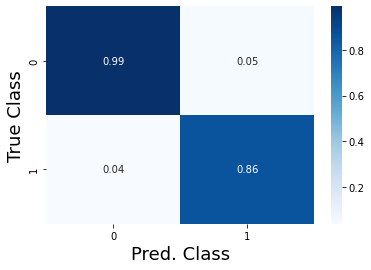

In [14]:
# and then we calculated the performance of model on testing dataset

y_pred = cross_val_predict(clf_svm, X_test, Y_test, cv=5)

# print the performance metrics (precison, recall and f1 score) on testing dataset

print("Testing metrics \n",classification_report(Y_test, y_pred,target_names=['Non-Seizure','Seizure']))

# let us plot the confusion matrix of trained model on test data
cm = confusion_matrix(Y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.heatmap(round((df_cm/df_cm.sum(axis=1)),2), annot=True,fmt='g',cmap ='Blues')

plt.xlabel('Pred. Class',fontsize=18)
plt.ylabel('True Class',fontsize=18)

## balance the dataset

In [15]:
# since there is not much difference in training and testing metrics,we can say that our model is not overfitting

The number of samples for the non-seizure class is: 9200
The number of samples for the seizure class is: 2300


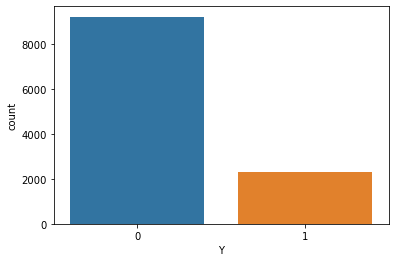

In [16]:
# visualize the percentage of classes in dataset

import seaborn as sn
cols = df.columns
tgt = df.Y
ax = sn.countplot(tgt,label="Count")
non_seizure, seizure = tgt.value_counts()
# p
print('The number of samples for the non-seizure class is:', non_seizure)
print('The number of samples for the seizure class is:', seizure)

In [17]:
# Since most of the data are from non-seizure, the dataset is highly imbalanced.So we used SMOTE to balnace the dataset
#which consists of synthesizing elements for the minority class, based on those that already exist.

The number of samples for the non-seizure class is: 9200
The number of samples for the seizure class is: 9200


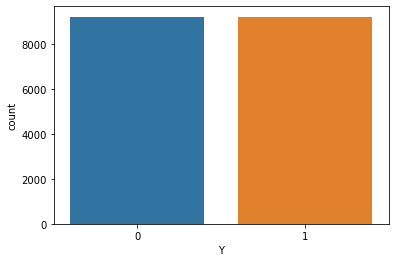

In [18]:
from imblearn.over_sampling import SMOTE

Yd=df["Y"]
Yd = Yd.astype('int')
Xd=df.drop(["Y"],axis=1)
Xd.head()

sm = SMOTE(random_state=40)

X_sm, Y_sm = sm.fit_resample(Xd, Yd)
ax = sn.countplot(Y_sm, label="Count")
non_seizure = np.count_nonzero(Y_sm == 0)
seizure = np.count_nonzero(Y_sm == 1)
print('The number of samples for the non-seizure class is:', non_seizure)
print('The number of samples for the seizure class is:', seizure)

In [19]:
# extract the features of balanced dataset using wavelet tranform

df3_fea=getWaveletFeatures(X_sm,Y_sm)
df3_fea = shuffle(df3_fea)
df3_fea.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
13669,-348.169313,-235.648892,336.448603,1.131977e+05,382.648015,30.622783,89.073330,805.301472,648510.461264,635.710624,...,3.184185,67.222551,4518.871373,56.524180,0.033236,-0.158345,8.805230,77.532071,6.849245,1
4504,20.098881,16.906375,173.360585,3.005389e+04,127.670120,-130.756939,-87.105879,222.704787,49597.421966,188.983054,...,0.104820,31.547086,995.218611,24.994412,0.018948,0.081010,4.342489,18.857212,3.496772,0
15997,-1049.321970,-678.952638,1094.412255,1.197738e+06,1111.989052,-7.003256,34.094671,167.437425,28035.291200,116.014480,...,-4.754067,93.749926,8789.048573,59.296341,-0.076083,-0.167675,13.937541,194.255059,9.097504,1
6288,162.233160,161.392683,139.735371,1.952597e+04,183.230496,1.680022,9.890989,38.870535,1510.918527,29.170332,...,0.757660,11.076072,122.679368,8.692622,-0.140438,-0.365895,3.453827,11.928918,2.745821,0
15051,-106.592673,-93.142228,181.106178,3.279945e+04,162.715578,-7.322277,13.760537,292.807792,85736.403085,170.178463,...,0.797516,29.721529,883.369312,17.788133,-0.139184,-0.148978,4.372438,19.118216,2.845984,1


In [20]:
Xb = df3_fea.iloc[:,0:24].values
Yb = df3_fea.iloc[:,25].values

# to train the SVM model we normalized the dataset using standardscalar
scaler = StandardScaler()
scaler.fit(Xb)
Xb = scaler.transform(Xb)

# split the balanced dataset in training (80%) and testing (20%) dataset
Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(Xb, Yb, test_size = 0.2)
Xb_train, Xb_val, Yb_train, Yb_val = train_test_split(Xb_train, Yb_train, test_size=0.13, random_state=1) 

In [21]:
# we trained the SVM model on balanced dataset


svmclf2 = SVC(kernel='rbf', probability=True)

# let us define the hyperparameters of SVM model
param_grid2 = {
    'C':   [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly','rbf'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [1, 2, 3, 4, 5]}

searchSVM2 = RandomizedSearchCV(svmclf2, param_grid2, cv = 5, 
                              n_iter=5, scoring ='accuracy',
                              refit='precision',
                              return_train_score=False,
                              n_jobs=-1,
                              verbose=1)
searchSVM2.fit(Xb_train,Yb_train)

SVM2 = searchSVM2.best_params_

clf_svm2 = SVC(
    C = SVM2['C'], 
    kernel = SVM2['kernel'], 
    gamma = SVM2['gamma'],
    degree = SVM2['degree'],probability=True)

clf_svm2.fit(Xb_train,Yb_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


SVC(C=0.01, degree=4, gamma=0.001, kernel='linear', probability=True)

In [22]:
# let us check whether the model is overfitting or not
# we calculated the performance of model on training dataset
y_predtrain2 = cross_val_predict(clf_svm2, Xb_val, Yb_val, cv=5)
print("Training metrics\n",classification_report(Yb_val, y_predtrain2,target_names=['Non-Seizure','Seizure']))

Training metrics
               precision    recall  f1-score   support

 Non-Seizure       0.88      0.96      0.92       942
     Seizure       0.96      0.88      0.92       972

    accuracy                           0.92      1914
   macro avg       0.92      0.92      0.92      1914
weighted avg       0.92      0.92      0.92      1914



Testing metrics
               precision    recall  f1-score   support

 Non-Seizure       0.90      0.96      0.93      1844
     Seizure       0.95      0.90      0.93      1836

    accuracy                           0.93      3680
   macro avg       0.93      0.93      0.93      3680
weighted avg       0.93      0.93      0.93      3680



Text(33.0, 0.5, 'True Class')

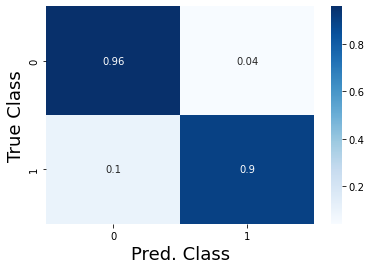

In [23]:
# let us evaluate the performance of SVM model on balanced dataset

y_predb = cross_val_predict(clf_svm2, Xb_test, Yb_test, cv=5)
print("Testing metrics\n",classification_report(Yb_test, y_predb,target_names=['Non-Seizure','Seizure']))

# confusion matrix
cmb = confusion_matrix(Yb_test, y_predb)
df_cmb = pd.DataFrame(cmb, range(2), range(2))
sn.heatmap(round((df_cmb/df_cmb.sum(axis=1)),2), annot=True,fmt='g',cmap ='Blues')

plt.xlabel('Pred. Class',fontsize=18)
plt.ylabel('True Class',fontsize=18)

## LSTM model

In [24]:
## Now the second model used in this work to for seizure detection is LSTM

In [25]:
# we used the original dataset
from keras.utils import to_categorical
df = shuffle(df)
X1 = df.iloc[:,1:177].values
Y1 = df.iloc[:,178].values

# scaling the data using standard scalar
scaler = StandardScaler()
scaler.fit(X1)
X1 = scaler.transform(X1)

Y1 = to_categorical(Y1)

# divide the dataset into training (60%) validation (20%) and testing dataset(20%)
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.2)
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X1_train, Y1_train, test_size=0.13, random_state=1) 

X1_train = np.reshape(X1_train, (X1_train.shape[0],1,X1.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0],1,X1.shape[1]))
X1_val = np.reshape(X1_val, (X1_val.shape[0],1,X1.shape[1]))

In [26]:
# import all the library neccesary for LSTM

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.optimizers import SGD
from keras_tuner import RandomSearch

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

In [27]:
#  to find the the optimal number of LSTM layers we used hp.int() in a for loop, which could take value 1 to 4.
# To avoid overfitting the neural network, we add a dropout layer and to find the right drop out we used hp.Float().
# and defined the the final layer as dense layer
#After defining the hyper-parameters we compiled the model with Adam optimizer,
# binary cross-Entropy loss function, and metric and return that model

# we used early stopping to Stop the training when a monitored metric has stopped improving.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  


def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=16,max_value=512,step=16), activation=hp.Choice('activation1',values=['relu', 'sigmoid']),return_sequences=True, input_shape=(X1_train.shape[1],X1_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=16,max_value=512,step=16),activation=hp.Choice('activation2',values=['relu', 'sigmoid']),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=16,max_value=512,step=16),activation=hp.Choice('activation3',values=['relu', 'sigmoid'])))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.9,step=0.1)))
    model.add(Dense(Y1_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid','softmax'])))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


In [28]:
#To find the best model we used  hyperband to optimize the hyperparameters
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory=r'D:\Final_project\Save_model\binaryclass', # path of directory to save the model 
                     project_name='Best_model4')

INFO:tensorflow:Reloading Oracle from existing project D:\Final_project\Save_model\binaryclass\Best_model4\oracle.json
INFO:tensorflow:Reloading Tuner from D:\Final_project\Save_model\binaryclass\Best_model4\tuner0.json


In [29]:
# after defining the tuner we used search method to find the best model and save the models
tuner.search(
        x=X1_train,
        y=Y1_train,
        epochs=50,
        validation_data=(X1_val,Y1_val),
        callbacks=[stop_early]
        )

INFO:tensorflow:Oracle triggered exit


In [30]:
# hyperparameters of best models
tuner.results_summary()

Results summary
Results in D:\Final_project\Save_model\binaryclass\Best_model4
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 176
activation1: relu
n_layers: 2
lstm_0_units: 304
activation2: sigmoid
layer_2_neurons: 336
activation3: relu
Dropout_rate: 0.6000000000000001
dense_activation: softmax
learning_rate: 0.001
lstm_1_units: 480
lstm_2_units: 224
lstm_3_units: 400
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9882943034172058
Trial summary
Hyperparameters:
input_unit: 496
activation1: relu
n_layers: 1
lstm_0_units: 224
activation2: relu
layer_2_neurons: 224
activation3: sigmoid
Dropout_rate: 0.5
dense_activation: softmax
learning_rate: 0.001
lstm_1_units: 432
lstm_2_units: 448
lstm_3_units: 400
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0052
Score: 0.985785961151123
Trial summary
Hyperparameters:
input_unit: 208
activation1: sigmoid
n_layers: 3
lstm_0_units: 208
activation2: sigmoid


In [31]:
# we extract the best model using the get_best_models method of the tuner instance
best_model = tuner.get_best_models()[0]
best_model.build(X1_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 176)            248512    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 304)            584896    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 480)            1507200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 336)               1098048   
_________________________________________________________________
dropout (Dropout)            (None, 336)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 674       
Total params: 3,439,330
Trainable params: 3,439,330
Non-trainable params: 0
______________________________________________

In [32]:
# now we trained the best model using the fit method
best_model.fit(X1_train,Y1_train,epochs=50,
        validation_data=(X1_val,Y1_val),
        batch_size = 16,
        callbacks=[stop_early])

Epoch 1/50
501/501 [==============================] - 8s 16ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0407 - val_accuracy: 0.9833
Epoch 2/50
501/501 [==============================] - 7s 15ms/step - loss: 0.0291 - accuracy: 0.9896 - val_loss: 0.0395 - val_accuracy: 0.9858
Epoch 3/50
501/501 [==============================] - 7s 14ms/step - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.0654 - val_accuracy: 0.9833
Epoch 4/50
501/501 [==============================] - 7s 14ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0617 - val_accuracy: 0.9833
Epoch 5/50
501/501 [==============================] - 7s 14ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0434 - val_accuracy: 0.9875
Epoch 6/50
501/501 [==============================] - 7s 15ms/step - loss: 0.0088 - accuracy: 0.9965 - val_loss: 0.0885 - val_accuracy: 0.9858
Epoch 7/50
501/501 [==============================] - 7s 15ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.0529 - val_accuracy: 0.9833

              precision    recall  f1-score   support

 Non-seizure       0.99      0.99      0.99      1837
     Seizure       0.94      0.96      0.95       463

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



Text(33.0, 0.5, 'True Class')

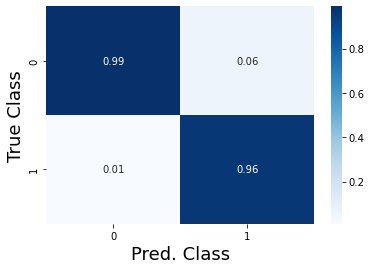

In [33]:
# evaluate the performance of best model on test data
Y_pred = best_model.predict(X1_test)
print(classification_report(Y1_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=['Non-seizure', 'Seizure']))

#confusion matrix

cml = confusion_matrix(Y1_test.argmax(axis=1), Y_pred.argmax(axis=1))
df_cml = pd.DataFrame(cml, range(2), range(2))
sn.heatmap(round((df_cml/df_cml.sum(axis=1)),2), annot=True,fmt='g',cmap ='Blues')

plt.xlabel('Pred. Class',fontsize=18)
plt.ylabel('True Class',fontsize=18)

## LSTM model on balanced dataset

In [34]:
# Now test the perforamnce of LSTM model on balanced dataset

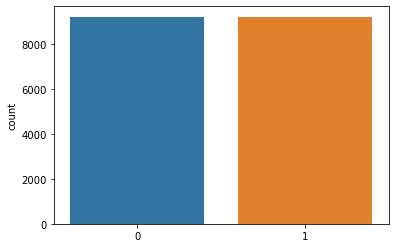

In [35]:
df_sm = shuffle(df)
X2 = df_sm.iloc[:,1:177].values
Y2 = df_sm.iloc[:,178].values
# define SMOTE
sm = SMOTE(random_state=40)

X1_sm, Y1_sm = sm.fit_resample(X2, Y2)
ax = sn.countplot(Y1_sm,label="Count")


In [36]:
# scaling the data using standard scalar
scaler = StandardScaler()
scaler.fit(X1_sm)
X1_sm = scaler.transform(X1_sm)

Y1_sm = to_categorical(Y1_sm)

# divide the dataset into training (60%) validation (20%) and testing dataset(20%)
X1sm_train, X1sm_test, Y1sm_train, Y1sm_test = train_test_split(X1_sm, Y1_sm, test_size = 0.2)
X1sm_train, X1sm_val, Y1sm_train, Y1sm_val = train_test_split(X1sm_train, Y1sm_train, test_size=0.13, random_state=1) 

X1sm_train = np.reshape(X1sm_train, (X1sm_train.shape[0],1,X1_sm.shape[1]))
X1sm_test = np.reshape(X1sm_test, (X1sm_test.shape[0],1,X1_sm.shape[1]))
X1sm_val = np.reshape(X1sm_val, (X1sm_val.shape[0],1,X1_sm.shape[1]))

In [37]:
# define the LSTM model for balanced dataset

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


def build_model2(hp):
    model2 = Sequential()
    model2.add(LSTM(hp.Int('input_unit',min_value=16,max_value=512,step=16), activation=hp.Choice('activation1',values=['relu', 'sigmoid']),return_sequences=True, input_shape=(X1_train.shape[1],X1_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model2.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=16,max_value=512,step=16),activation=hp.Choice('activation2',values=['relu', 'sigmoid']),return_sequences=True))
    model2.add(LSTM(hp.Int('layer_2_neurons',min_value=16,max_value=512,step=16),activation=hp.Choice('activation3',values=['relu', 'sigmoid'])))
    model2.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.9,step=0.1)))
    model2.add(Dense(Y1_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid','softmax'])))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model2.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model2

In [38]:
X1_train.shape[2]

176

In [39]:
#To find the best model we used  hyperband to optimize the hyperparameters
tuner2 = kt.Hyperband(build_model2,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory=r'D:\Final_project\Save_model\binaryclass', # path of directory to save the model
                     project_name='Best_modelsm4')

INFO:tensorflow:Reloading Oracle from existing project D:\Final_project\Save_model\binaryclass\Best_modelsm4\oracle.json
INFO:tensorflow:Reloading Tuner from D:\Final_project\Save_model\binaryclass\Best_modelsm4\tuner0.json


In [40]:
# after defining the tuner we used search method to find the best model and save the models
tuner2.search(
        x=X1sm_train,
        y=Y1sm_train,
        epochs=50,
        validation_data=(X1sm_val,Y1sm_val),
        callbacks=[stop_early]
        )

INFO:tensorflow:Oracle triggered exit


In [41]:
# hyperparameters of best models
tuner2.results_summary()

Results summary
Results in D:\Final_project\Save_model\binaryclass\Best_modelsm4
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 336
activation1: relu
n_layers: 3
lstm_0_units: 400
activation2: sigmoid
layer_2_neurons: 416
activation3: relu
Dropout_rate: 0.2
dense_activation: softmax
learning_rate: 0.001
lstm_1_units: 208
lstm_2_units: 160
lstm_3_units: 112
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.9879832863807678
Trial summary
Hyperparameters:
input_unit: 480
activation1: relu
n_layers: 4
lstm_0_units: 512
activation2: relu
layer_2_neurons: 288
activation3: sigmoid
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
learning_rate: 0.001
lstm_1_units: 320
lstm_2_units: 432
lstm_3_units: 448
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.9874607920646667
Trial summary
Hyperparameters:
input_unit: 336
activation1: relu
n_layers: 3
lstm_0_units: 4

In [42]:
# let us choose the best model
best_model2 = tuner2.get_best_models()[0]
best_model2.build(X1sm_train.shape)
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 336)            689472    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 400)            1179200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 208)            506688    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 160)            236160    
_________________________________________________________________
lstm_4 (LSTM)                (None, 416)               960128    
_________________________________________________________________
dropout (Dropout)            (None, 416)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 8

In [43]:
# now we trained the best model using the fit method
best_model2.fit(X1sm_train,Y1sm_train,epochs=50,
        validation_data=(X1sm_val,Y1sm_val),
        batch_size = 16,
        callbacks=[stop_early])

Epoch 1/50
801/801 [==============================] - 13s 16ms/step - loss: 0.0403 - accuracy: 0.9885 - val_loss: 0.0439 - val_accuracy: 0.9875
Epoch 2/50
801/801 [==============================] - 12s 15ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0321 - val_accuracy: 0.9896
Epoch 3/50
801/801 [==============================] - 12s 15ms/step - loss: 0.0148 - accuracy: 0.9966 - val_loss: 0.0371 - val_accuracy: 0.9890
Epoch 4/50
801/801 [==============================] - 12s 15ms/step - loss: 0.0115 - accuracy: 0.9959 - val_loss: 0.0457 - val_accuracy: 0.9896
Epoch 5/50
801/801 [==============================] - 12s 15ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0331 - val_accuracy: 0.9916
Epoch 6/50
801/801 [==============================] - 12s 15ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.0593 - val_accuracy: 0.9901
Epoch 7/50
801/801 [==============================] - 12s 16ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0653 - val_accuracy:

              precision    recall  f1-score   support

 Non-seizure       1.00      0.99      0.99      1785
     Seizure       0.99      1.00      0.99      1895

    accuracy                           0.99      3680
   macro avg       0.99      0.99      0.99      3680
weighted avg       0.99      0.99      0.99      3680



Text(33.0, 0.5, 'True Class')

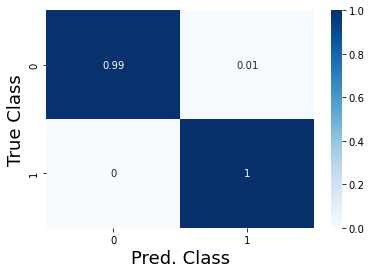

In [44]:
# predict the performance of best model on test
Y2_pred = best_model2.predict(X1sm_test)

# print the performance metrics (precison, recall and f1 score) on testing dataset
print(classification_report(Y1sm_test.argmax(axis=1), Y2_pred.argmax(axis=1), target_names=['Non-seizure', 'Seizure']))

# plot the confusion matrix
cml2 = confusion_matrix(Y1sm_test.argmax(axis=1), Y2_pred.argmax(axis=1))
df_cml2 = pd.DataFrame(cml2, range(2), range(2))
sn.heatmap(round((df_cml2/df_cml2.sum(axis=1)),2), annot=True,fmt='g',cmap ='Blues')

plt.xlabel('Pred. Class',fontsize=18)
plt.ylabel('True Class',fontsize=18)

In [46]:
# Gaussian Naive Bayes classifier is used as benchmark clasifier

In [47]:
from sklearn.naive_bayes import GaussianNB
NBclf = GaussianNB()

# parameter Gaussian Naive Bayes classifier
param_grid3 = {
    'var_smoothing': np.logspace(0,-9, num=10)}

# Random search with five fold cross validation
searchNB = RandomizedSearchCV(NBclf, param_grid3, cv = 5, 
                              n_iter=5, scoring ='accuracy',
                              refit='precision',
                              return_train_score=False,
                              n_jobs=-1,
                              verbose=1)

# search the best hyperparameters of Gaussian Naive Bayes classifier
searchNB.fit(Xb_train, Yb_train)
NB = searchNB.best_params_

# train the Gaussian Naive Bayes classifier with best hyperparameters
clf_NB = GaussianNB(
    var_smoothing= NB['var_smoothing'])

clf_NB.fit(Xb_train,Yb_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GaussianNB(var_smoothing=1e-07)

In [48]:
y_predtrainNB = cross_val_predict(clf_NB, Xb_val, Yb_val, cv=5)
print("Training metrics\n",classification_report(Yb_val, y_predtrainNB,target_names=['Non-Seizure','Seizure']))

Training metrics
               precision    recall  f1-score   support

 Non-Seizure       0.77      0.96      0.86       942
     Seizure       0.95      0.73      0.83       972

    accuracy                           0.84      1914
   macro avg       0.86      0.85      0.84      1914
weighted avg       0.86      0.84      0.84      1914



Testing metrics
               precision    recall  f1-score   support

 Non-Seizure       0.82      0.96      0.88      1844
     Seizure       0.95      0.78      0.86      1836

    accuracy                           0.87      3680
   macro avg       0.88      0.87      0.87      3680
weighted avg       0.88      0.87      0.87      3680



Text(33.0, 0.5, 'True Class')

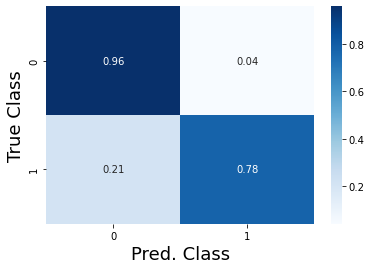

In [49]:
y_predNB = cross_val_predict(clf_NB, Xb_test, Yb_test, cv=5)
print("Testing metrics\n",classification_report(Yb_test, y_predNB,target_names=['Non-Seizure','Seizure']))

# confusion matrix
cmNB = confusion_matrix(Yb_test, y_predNB)
df_cmNB = pd.DataFrame(cmNB, range(2), range(2))
sn.heatmap(round((df_cmNB/df_cmNB.sum(axis=1)),2), annot=True,fmt='g',cmap ='Blues')

plt.xlabel('Pred. Class',fontsize=18)
plt.ylabel('True Class',fontsize=18)

## ROC curves of all models

In [50]:
pred_prob1 = clf_svm.predict_proba(X_test) # SVM model on unbalanced dataset
pred_prob2 = clf_svm2.predict_proba(Xb_test) #SVM model on balanced dataset
pred_prob3 = best_model.predict_proba(X1_test) # LSTM model on unbalanced dataset
pred_prob4 = best_model2.predict_proba(X1sm_test) #LSTM model on balanced dataset

pred_prob5 = clf_NB.predict_proba(Xb_test)

Instructions for updating:
Please use `model.predict()` instead.


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(Yb_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(Y1_test.argmax(axis=1), pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(Y1sm_test.argmax(axis=1), pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(Yb_test, pred_prob5[:,1], pos_label=1)
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

In [52]:
from sklearn import metrics
auc1 = metrics.roc_auc_score(Y_test, pred_prob1[:,1])
auc2 = metrics.roc_auc_score(Yb_test, pred_prob2[:,1])
auc3 = metrics.roc_auc_score(Y1_test.argmax(axis=1), pred_prob3[:,1])
auc4 = metrics.roc_auc_score(Y1sm_test.argmax(axis=1), pred_prob4[:,1])
auc5 = metrics.roc_auc_score(Yb_test, pred_prob5[:,1])

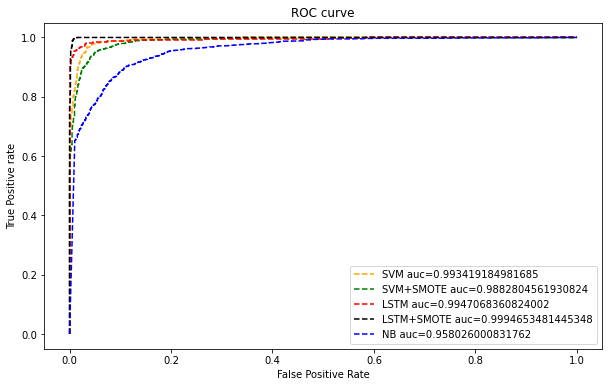

In [54]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 6))
plt.clf()

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label="SVM auc="+str(auc1))
plt.plot(fpr2, tpr2, linestyle='--',color='green', label="SVM+SMOTE auc="+str(auc2))
plt.plot(fpr3, tpr3, linestyle='--',color='red', label="LSTM auc="+str(auc3))
plt.plot(fpr4, tpr4, linestyle='--',color='black', label="LSTM+SMOTE auc="+str(auc4))
plt.plot(fpr5, tpr5, linestyle='--',color='blue', label="NB auc="+str(auc5))
#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
